[('601988', '601398', 0.004470652810505051), ('601988', '601939', 0.026075016065410583), ('601988', '600036', 0.026471907303914688), ('601398', '600036', 0.04685775942491412), ('601939', '600036', 0.0357455746856612), ('601818', '601166', 0.00823604908696474)]
                            OLS Regression Results                            
Dep. Variable:                 601166   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     2561.
Date:                Mon, 09 Jul 2018   Prob (F-statistic):          3.23e-223
Time:                        21:41:41   Log-Likelihood:                -500.23
No. Observations:                 627   AIC:                             1004.
Df Residuals:                     625   BIC:                             1013.
Df Model:                           1                                         
Covariance Type:            

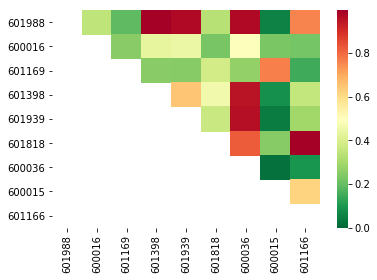

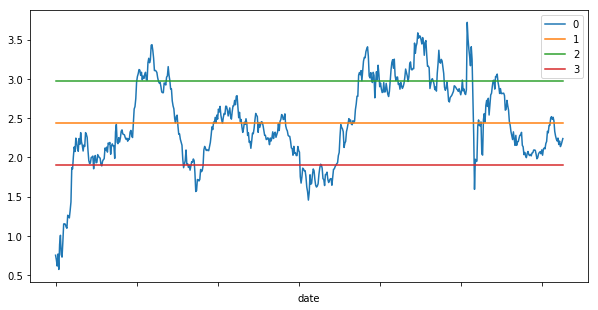

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 29 10:27:35 2017

@author: Administrator
"""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tushare as ts
import statsmodels.api as sm
import seaborn as sns


#我们来只管看一下一个平稳的序列长什么样，
#最简单的一个噪声序列他就是一个平稳的序列。

#np.random.seed(1234)
#x = np.random.normal(0, 1, 500)
#X = pd.Series(x) + 100
#X.plot(figsize=(14,7))

#上图构建了一个以100为均值的噪声序列，
#可以看出这个序列的期望与方差协方差均不随时间而改变。
#我们来看看两个序列本身是非平稳的序列是怎么样的。
#
#np.random.seed(1234)
#x = np.random.normal(0, 1, 1000)
#y = np.random.normal(0, 1, 1000)
#X = pd.Series(x) + 100
#Y = X + y + 30
#for i in range(1000):
#    X[i] = X[i] - i/10
#    Y[i] = Y[i] - i/10
##X.plot(figsize=(14,7));
###plt.hold()
##Y.plot(figsize=(14,7));
##plt.xlabel("Time"); 
##plt.ylabel("Price");
##plt.legend(["X", "Y"]);
#
###可以看出期望是随时间递减的，明显不是平稳序列，
###我们通过差分来看看是否能构造平稳序列。
#Z=X-Y
#Z.plot(figsize=(14,7));
#plt.xlabel("Time"); 
#plt.ylabel("Price");
#plt.legend(["X", "Y"]);
#
##通过差分我们得到的就是一个跟噪声序列长的一样的平稳序列了。 
##那么一般股票序列是非平稳的我们怎么去找协整关系构建平稳的序列呢。
#
#定义函数进行协整性计算
def find_cointegrated_pairs(dataframe):
    # 得到DataFrame长度
    n = dataframe.shape[1]
    # 初始化p值矩阵
    pvalue_matrix = np.ones((n, n))
    # 抽取列的名称
    keys = dataframe.keys()
    # 初始化强协整组
    pairs = []
    # 对于每一个i
    for i in range(n):
        # 对于大于i的j
        for j in range(i+1, n):
            # 获取相应的两只股票的价格Series
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            # 分析它们的协整关系
            result = sm.tsa.stattools.coint(stock1, stock2)
            # 取出并记录p值
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            # 如果p值小于0.05
            if pvalue < 0.05:
                # 记录股票对和相应的p值
                pairs.append((keys[i], keys[j], pvalue))
    # 返回结果
    return pvalue_matrix, pairs

 #选出一组股票列表
stock = pd.DataFrame()
list = ['601988','600016','601169','601398','601939','601818','600036','600015','601166']
#list =['601988','600016','601169','601997','600926','601818','600919','600000','601288','601128','600908','601328','601398','600036','601939','600015','601166','601009','601229']
df = ts.get_k_data(list[0])[['date','close']].set_index('date')
df.columns=[list[0]]
for i in list[1:]:
    ds =ts.get_k_data(i)[['date','close']].set_index('date')
    ds.columns=[i]
    df=df.merge(ds,right_index=True,left_index=True)
    
    
#获得强协整性股票对
pvalues, pairs = find_cointegrated_pairs(df)
#以热力图来形象表示
sns.heatmap(1-pvalues, xticklabels=list, yticklabels=list, cmap='RdYlGn_r', mask = (pvalues == 1))
#打印出强协整股票对
print (pairs)

#
#
##从选出的股票里挑选p值最低的，也就是我们认为最符合协整关系的来看看他们之间的股价走势是怎么样的.
stock_sample1 = df['601818']
stock_sample2 = df['601166']
#stock_sample1.plot(figsize=(10,5));
#stock_sample2.plot(figsize=(10,5));
#plt.xlabel("Time"); 
#plt.ylabel("Price");
#plt.legend(['601398', '600015']);

#
##要利用这组股票对进行配对交易，就得看看他们之间的存在什么样的线性关系。
##这里我们通过股价进行最小残差平方和（OLS）方法来进行回归。
x = stock_sample1
y = stock_sample2
X = sm.add_constant(x)
result = (sm.OLS(y,X)).fit()
print(result.summary())

##接下来我们看看线性组合的价差是否是在均值周围波动。
##
diff=y-3.3207*x
mean=np.mean(diff)
std=np.std(diff)
print(std)
up=mean+std
down=mean-std
time=diff.index
mean_line=pd.Series(mean,index=time)
up_line=pd.Series(up,index=time)
down_line=pd.Series(down,index=time)
set=pd.concat([diff,mean_line,up_line,down_line],axis=1)
set.plot(figsize=(10,5))